In [1]:
from collections import defaultdict
import os, urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn, sklearn.model_selection, sklearn.linear_model

from projection_simplex_vectorized import projection_simplex
import postprocess

split_ratio_for_postprocessing = 0.5

seed = 33
rng = np.random.default_rng(seed)
noise_fn = lambda shape: rng.laplace(loc=0.0, scale=0.2 / 5, size=shape)
n_perturbations = 10

## Download and pre-process UCI Communities and Crime dataset

In [2]:
features = [
    "state", "county", "community", "communityname", "fold", "population",
    "householdsize", "racepctblack", "racePctWhite", "racePctAsian",
    "racePctHisp", "agePct12t21", "agePct12t29", "agePct16t24", "agePct65up",
    "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf",
    "pctWInvInc", "pctWSocSec", "pctWPubAsst", "pctWRetire", "medFamInc",
    "perCapInc", "whitePerCap", "blackPerCap", "indianPerCap", "AsianPerCap",
    "OtherPerCap", "HispPerCap", "NumUnderPov", "PctPopUnderPov",
    "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", "PctUnemployed",
    "PctEmploy", "PctEmplManu", "PctEmplProfServ", "PctOccupManu",
    "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", "FemalePctDiv",
    "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par",
    "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom",
    "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5",
    "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5",
    "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell",
    "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous",
    "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup",
    "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant",
    "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos",
    "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart",
    "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ",
    "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg",
    "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState",
    "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT",
    "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop",
    "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic", "PolicPerPop",
    "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp",
    "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits",
    "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea", "PopDens",
    "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr",
    "LemasGangUnitDeploy", "LemasPctOfficDrugUn", "PolicBudgPerPop",
    "ViolentCrimesPerPop"
]

data_path = "data/communities/communities.data"
if not os.path.exists(data_path):
  os.makedirs("data/communities", exist_ok=True)
  urllib.request.urlretrieve(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
      data_path)

original = pd.read_csv(data_path,
                       names=features,
                       sep=r",",
                       engine="python",
                       na_values="?")

# Drop community name, state, and county, and columns with missing values
original = original.drop(["communityname", "state", "county"],
                         axis=1).dropna(axis=1)

In [3]:
def data_transform(df):
  """Normalize features."""
  binary_data = pd.get_dummies(df)
  scaler = sklearn.preprocessing.StandardScaler()
  data = pd.DataFrame(scaler.fit_transform(binary_data),
                      columns=binary_data.columns)
  data.index = df.index
  return data


# Create 5 equidistance bins for ViolentCrimesPerPop column
labels_original = pd.cut(original["ViolentCrimesPerPop"], 5)

# Get sensitive attributes
minority_pct = np.stack([
    original[a].to_numpy()
    for a in ["racePctHisp", "racePctAsian", "racepctblack"]
],
                        axis=1)
minority_presence = np.array(["hispanic", "asian",
                              "black"])[minority_pct.argmax(axis=1)]
minority_presence[original["racePctWhite"] > 0.95] = "white"
original["MinorityPresence"] = minority_presence

label_names, labels = np.unique(labels_original, return_inverse=True)
n_labels = len(label_names)

data = original.copy()
data = data.drop(["ViolentCrimesPerPop", "fold"], axis=1)
data = data_transform(data)

In [4]:
def get_group_labels_and_print_statistics(sensitive_attributes):

  group_names, groups = np.unique(
      original[sensitive_attributes].to_numpy().astype(str),
      return_inverse=True,
      axis=0)
  n_groups = len(group_names)
  print("Demographic groups:",
        ', '.join(["'" + ', '.join(n) + "'" for n in group_names]))

  # Compute dataset statistics
  df = original.copy()
  df["Target"] = labels_original
  group_column = original[sensitive_attributes[0]]
  for attribute in sensitive_attributes[1:]:
    group_column = np.add(np.add(group_column, ", "), original[attribute])
  df["Group"] = group_column
  grouped = df.groupby(["Target", "Group"]).size().unstack()
  n_labels = len(grouped.index)
  n_groups = len(grouped.columns)
  counts = grouped.sum(axis=0)
  normalized = np.nan_to_num((grouped.to_numpy() / counts.to_numpy())).T
  diff = np.abs(normalized[:, None, :] - normalized[None, :, :])
  postprocessor = postprocess.PostProcessorDP()
  postprocessor.fit(np.concatenate([np.eye(n_labels) for _ in range(n_groups)],
                                   axis=0),
                    np.repeat(np.arange(n_groups), n_labels),
                    p=normalized.flatten())
  res = {
      "balanced_accuracy": {
          "perfect_postprocessed": (n_groups - postprocessor.score_) / n_groups
      },
      "dp_gap_linf_max": {
          "perfect_predictor": np.max(diff)
      },
      "dp_gap_l1_max": {
          "perfect_predictor": np.max(1 / 2 * np.sum(diff, axis=2))
      },
      "dp_gap_l1_avg": {
          "perfect_predictor":
              np.mean(1 / 2 * np.sum(diff, axis=2)[np.triu_indices(n_groups, 1)]
                     )
      },
  }

  display(pd.DataFrame(res))
  display(grouped / counts)
  display(pd.DataFrame(counts, columns=["Count"]).T)

  return groups, n_groups

In [5]:
sensitive_attributes = ["MinorityPresence"]
groups, n_groups = get_group_labels_and_print_statistics(sensitive_attributes)

Demographic groups: 'asian', 'black', 'hispanic', 'white'


,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
perfect_postprocessed,0.766781,NaN,NaN,NaN
perfect_predictor,NaN,0.581516,0.581516,0.363946


Group,asian,black,hispanic,white
Target,,,,
"(-0.001, 0.2]",0.768683,0.340625,0.417323,0.922141
"(0.2, 0.4]",0.156584,0.279687,0.367454,0.060827
"(0.4, 0.6]",0.032028,0.185938,0.131234,0.012165
"(0.6, 0.8]",0.028470,0.092188,0.049869,0.002433
"(0.8, 1.0]",0.014235,0.101562,0.034121,0.002433


Group,asian,black,hispanic,white
Count,562,640,381,411


## Post-process

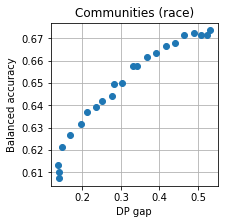

,accuracy,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
inf,0.661510,0.673644,0.532059,0.532059,0.338814
0.5,0.659510,0.671309,0.519798,0.523049,0.335162
0.48,0.659513,0.671617,0.504172,0.507423,0.327165
0.45,0.660520,0.672465,0.485837,0.488383,0.312971
0.42,0.660020,0.671431,0.459874,0.464203,0.296898
0.4,0.656013,0.667856,0.435342,0.439671,0.282624
0.38,0.655005,0.666605,0.416819,0.416994,0.268478
0.35,0.651997,0.663411,0.388096,0.390421,0.254090
0.32,0.649982,0.661559,0.364242,0.367569,0.241549
0.3,0.645970,0.657761,0.339434,0.342761,0.227811


In [6]:
eps = [
    0.5, 0.48, 0.45, 0.42, 0.4, 0.38, 0.35, 0.32, 0.3, 0.28, 0.25, 0.22, 0.2,
    0.18, 0.15, 0.12, 0.1, 0.08, 0.05, 0.02, 0.01, 0.0
]
res = defaultdict(dict)

for e in eps:

  all_r = []

  # print("Fold...", end="", flush=True)
  for fold in original["fold"].unique():
    # print(f"{fold} ", end="", flush=True)

    train_data = data[original["fold"] != fold]
    train_labels = labels[original["fold"] != fold]
    train_groups = groups[original["fold"] != fold]
    test_data = data[original["fold"] == fold]
    test_labels = labels[original["fold"] == fold]
    test_groups = groups[original["fold"] == fold]

    # Train data split
    train_data_pre, train_data_post, train_labels_pre, train_labels_post, train_groups_pre, train_groups_post = sklearn.model_selection.train_test_split(
        train_data,
        train_labels,
        train_groups,
        test_size=split_ratio_for_postprocessing,
        random_state=seed)

    train_labels_pre_one_hot = pd.get_dummies(train_labels_pre)

    predictor = sklearn.linear_model.LinearRegression()
    predictor.fit(train_data_pre, train_labels_pre_one_hot)
    predict_fn = lambda X: projection_simplex(predictor.predict(X), axis=1)
    postprocessor = postprocess.postprocess(predict_fn,
                                            train_data_post,
                                            train_groups_post,
                                            eps=e)
    all_r.append(
        postprocess.evaluate(predict_fn, postprocessor, test_data, test_labels,
                             test_groups, n_labels, n_groups))
    # print()

  r = {
      k1: {k2: np.mean([d[k1][k2] for d in all_r]) for k2 in all_r[0][k1]
          } for k1, v1 in all_r[0].items()
  }
  for k, v in r.items():
    res[k]["inf"] = v["predictor"]
    res[k][e] = v["postprocessor"]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(res["dp_gap_l1_max"].values(),
           res["balanced_accuracy"].values(),
           zorder=2)
ax.set_xlabel("DP gap")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Communities (race)")
ax.grid(True, which="both", zorder=0)
plt.show()
display(pd.DataFrame(res))

In [7]:
all_r = []

# print("Fold...", end="", flush=True)
for fold in original["fold"].unique():
  # print(f"{fold} ", end="", flush=True)

  train_data = data[original["fold"] != fold]
  train_labels = labels[original["fold"] != fold]
  train_groups = groups[original["fold"] != fold]
  test_data = data[original["fold"] == fold]
  test_labels = labels[original["fold"] == fold]
  test_groups = groups[original["fold"] == fold]

  # Train data split
  train_data_pre, train_data_post, train_labels_pre, train_labels_post, train_groups_pre, train_groups_post = sklearn.model_selection.train_test_split(
      train_data,
      train_labels,
      train_groups,
      test_size=split_ratio_for_postprocessing,
      random_state=seed)

  train_labels_pre_one_hot = pd.get_dummies(train_labels_pre)

  predictor = sklearn.linear_model.LinearRegression()
  predictor.fit(train_data_pre, train_labels_pre_one_hot)
  predict_fn = lambda X: projection_simplex(predictor.predict(X), axis=1)
  postprocessor = postprocess.postprocess(predict_fn,
                                          train_data_post,
                                          train_groups_post,
                                          noise_fn=noise_fn,
                                          n_perturbations=n_perturbations)
  all_r.append(
      postprocess.evaluate(predict_fn,
                           postprocessor,
                           test_data,
                           test_labels,
                           test_groups,
                           n_labels,
                           n_groups,
                           noise_fn=noise_fn,
                           n_perturbations=1000))
# print()

r = {
    k1: {k2: np.mean([d[k1][k2] for d in all_r]) for k2 in all_r[0][k1]
        } for k1, v1 in all_r[0].items()
}
res = {
    k: {
        "inf": v["predictor"],
        0.0: v["postprocessor"]
    } for k, v in r.items()
}
print("With Laplace smoothing:")
display(pd.DataFrame(res))

With Laplace smoothing:


,accuracy,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
inf,0.661948,0.674289,0.532238,0.532238,0.340846
0.0,0.598172,0.608269,0.108782,0.119111,0.074183
